# Import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH = "/content/drive/MyDrive/Spring_2022/Deep_Learning/DL_Project_Group3"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io
from skimage.transform import resize
import os.path as osp
import os
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.callbacks import LearningRateScheduler

# Image label read-ins

Read in labels for "Smiling" for every image from the given zip file

In [5]:
PATH_ATTRIBUTE = osp.join(PATH, "data/list_attr_celeba.csv.zip")
labels = pd.read_csv(PATH_ATTRIBUTE,usecols=['image_id','Smiling'])

In [6]:
labels.head(5)

,image_id,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,-1
3,000004.jpg,-1
4,000005.jpg,-1


Create a dataframe containing the path to the image and the image's "Smiling" label for the data inflow later.

In [ ]:
samples = {}
PATH_SAMPLE = osp.join(PATH,"data/raw")

for root,dirs,files in os.walk(PATH_SAMPLE):
  for f in files:
    batch = root.split("/")[-1]
    samples[osp.basename(f)] = osp.join("data/raw",batch,osp.basename(f))

In [ ]:
paths = pd.DataFrame.from_dict(samples,orient='index',columns=['path']).reset_index()

In [ ]:
df = paths.merge(labels, left_on='index', right_on='image_id', how='left')[['path','Smiling']]
df.Smiling = df.Smiling.apply(lambda x: "Smiling" if x==1 else "Non-Smiling")

In [ ]:
# save the dataframe as a csv file
df.to_csv("path_labels.csv",index=False)

# Read in data with ImageDataGenerator

In [ ]:
PATH_IMAGE = osp.join(PATH,"data/path_labels_cat.csv")

In [ ]:
df = pd.read_csv(PATH_IMAGE)

In [ ]:
df.groupby("Smiling").count()

,path
Smiling,
Non-Smiling,102336
Smiling,95264


In [ ]:
# randoly sample 8000 images from the original full dataset
df_sample = df.sample(8000,random_state=42)

In [ ]:
# split into training and testing sets
train, test = train_test_split(df_sample, test_size=0.2,random_state=42, stratify = df_sample[['Smiling']])

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.,
                           rotation_range=15,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           horizontal_flip=True)

In [ ]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=PATH,
    x_col="path",
    y_col="Smiling",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(218,178))

Found 6400 validated image filenames belonging to 2 classes.


In [ ]:
# defining the test set image generator
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=PATH,
    x_col="path",
    y_col="Smiling",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(218,178))

Found 1600 validated image filenames belonging to 2 classes.


# Modeling

In [9]:
tf.random.set_seed(1)

In [10]:
def make_CNN(input_shape,weight_decay=1e-4,show_model=True):
  model = Sequential()
  model.add(Conv2D(32, (4,4), kernel_regularizer=regularizers.l2(weight_decay),
                   activation='elu',
                   input_shape=input_shape, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (4,4), kernel_regularizer=regularizers.l2(weight_decay),
                   activation='elu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (4,4),
                   kernel_regularizer=regularizers.l2(weight_decay),
                   activation='elu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (4,4), kernel_regularizer=regularizers.l2(weight_decay),
                   activation='elu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (4,4), kernel_regularizer=regularizers.l2(weight_decay),
                   activation='elu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (4,4), kernel_regularizer=regularizers.l2(weight_decay),
                   activation='elu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(2, activation='softmax'))

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  if show_model: print(model.summary())
  return model

In [11]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 25:
        lrate = 0.0005
    if epoch > 50:
        lrate = 0.0003
    if epoch > 100:
        lrate = 0.0001
    return lrate

In [12]:
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=3),
    LearningRateScheduler(lr_schedule),
    ModelCheckpoint(filepath=osp.join(PATH,'models/best_model_cnn.h5'),
                    save_best_only=True)
]

In [13]:
model = make_CNN((218,178,3),show_model=False)

In [14]:
len(model.layers)

21

# Model Training

In [15]:
PATH_MODEL = osp.join(PATH,"models/best_model_cnn.h5")
model.load_weights(PATH_MODEL)

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file=osp.join(PATH,'models/cnn_model.png'),
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=150,
                    callbacks=my_callbacks)

# Model Evaluation

In [ ]:
score = model.evaluate(test_generator, verbose=0)
print(model.metrics_names)
print('Test loss:', score)

['loss', 'accuracy']
Test loss: [0.25503069162368774, 0.9156249761581421]


In [ ]:
predictions = model.predict(test_generator)

In [ ]:
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.labels

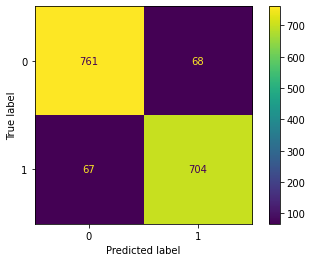

In [ ]:
# create confusion matrix
cm = confusion_matrix(true_classes,predicted_classes)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [ ]:
y_prob = predictions[:,1]
fpr, tpr, thresholds = roc_curve(true_classes, y_prob, pos_label=1)

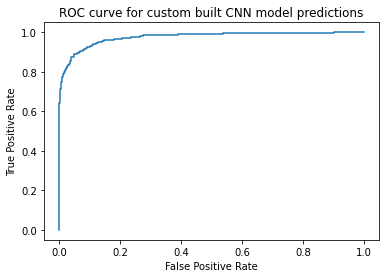

In [ ]:
plt.plot(fpr,tpr)
plt.title('ROC curve for custom built CNN model predictions')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Actual image test

In [34]:
def predict_image(model,path_to_image):
  """
  Given a model and image, 
  predict whether the person in the image is smiling or not.
  """
  # read in the image
  image = io.imread(path_to_image)
  # resize the image to fit the input shape of the model
  image_resized = np.expand_dims(resize(image
                                        ,(218, 178,3)
                                        ,anti_aliasing=True)
                                ,axis=0)
  # show the resized image
  plt.imshow(image_resized[0])
  # find the label of the image
  labels = sorted(['Non-smiling','Smiling'])
  y_prob = model.predict(image_resized)
  return labels[y_prob.argmax(axis=-1)[0]] 

In [37]:
# upload a sample of smiling image
from google.colab import files
uploaded = files.upload()

Saving 005068.jpg to 005068.jpg


'Smiling'

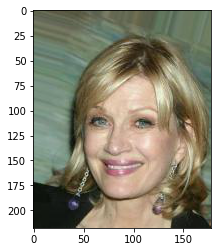

In [36]:
predict_image(model,"005013.jpg")

'Non-smiling'

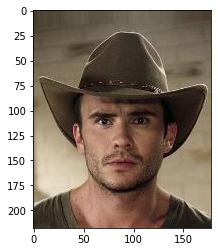

In [38]:
predict_image(model,"005068.jpg")

In [ ]:
%%shell
jupyter nbconvert --to html //Your notebook path file.ipynb